In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = [10, 5]


In [2]:
def calStability(raw, task_order, method):
    values = {k:[] for k in method}

    for t in task_order:
        rows = raw[raw["task_order"]==t]
        offline = rows[rows["method"]=="offline"]
        
        for m in method:                
            target = rows[rows["method"]==m]
            _m = target[target["task_index"]==1][["accuracy", "no_of_test", "no_of_correct_prediction"]]
            
            if m=="offline":
                continue
                
            
            _ideal = offline[offline["task_index"]==1]["accuracy"]
            val = float((_m["accuracy"]/float(_ideal)).sum()/len(_m))
            values[m].append(val)
    
    return values

In [3]:
def calPlasticity(raw, task_order, method):
    values = {k:[] for k in method}

    for t in task_order:
        rows = raw[raw["task_order"]==t]
        offline = rows[rows["method"]=="offline"]
        
        for m in method:
            _sum = 0.0
                
            target = rows[rows["method"]==m]
            train_session = target["train_session"].unique()
            
            if m=="offline":
                continue
    
            _m = target[target["train_session"]==(target["task_index"])][["accuracy", "no_of_test", "no_of_correct_prediction"]]
            
            _ideal = offline["accuracy"]
            val = _m["accuracy"].div(_ideal.values, axis=0).sum()/len(_m)
            values[m].append(val)
            
    
    return values

In [4]:
def calOverallAcc(raw, task_order, method):
    values = {k:[] for k in method}

    for t in task_order:
        rows = raw[raw["task_order"]==t]
        offline = rows[rows["method"]=="offline"]
        
        for m in method:
            if m=="offline":
                continue
                    
            _sum = 0.0
                
            target = rows[rows["method"]==m]
            
            task_index = target["task_index"].unique()
            train_session = target["train_session"].unique()
            
            _m = target[target["train_session"]==len(task_index)][["accuracy", "no_of_test", "no_of_correct_prediction"]]
            
            _ideal = offline["accuracy"]
            val = _m["accuracy"].div(_ideal.values, axis=0).sum()/len(_m)
            values[m].append(val)
            
    return values

In [5]:
all_values = {}
for d in ["HouseA", "CASAS", "PAMAP", "DSADS"]:
# for d in ["PAMAP"]:
    dataset = d
    folder = "../../Results/"+dataset+"/exp_no_of_hidden/"
    
    raw = pd.read_csv(folder+"results.txt")
    raw.columns = [c.strip() for c in raw.columns]
    raw["train_session"] = pd.to_numeric(raw["train_session"], errors='coerce')
    
    cmd = raw["cmd"].unique()
    task_order = raw["task_order"].unique()
    method = raw["method"].unique()

    stability = []
    plasticity = []
    overallAcc = []

    for c in cmd:
       
        target = raw[raw["cmd"]==c]
        m = calStability(target, task_order, method)
        stability.append(m)
        
        m = calPlasticity(target, task_order, method)
        plasticity.append(m)
        
        m = calOverallAcc(target, task_order, method)
        overallAcc.append(m)
        
    all_values[d] = (stability, plasticity, overallAcc)
    print(d, "DONE")

HouseA DONE
CASAS DONE
PAMAP DONE
DSADS DONE


# Hidden units per layer

sg-cgan [0.47698529018916114, 0.5227104708840105, 0.6480095117062112, 0.7925285297371907]


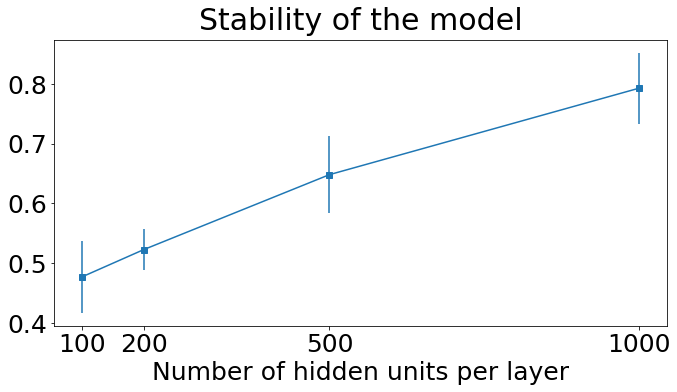

sg-cgan [1.1558137100097297, 1.1563116360126537, 1.1466411452356402, 1.1375944281774628]


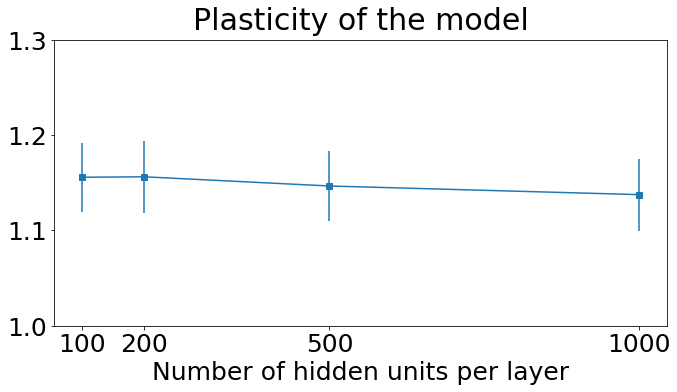

sg-cgan [0.5408542236769033, 0.6463827113854594, 0.7460909498017201, 0.847640972322486]


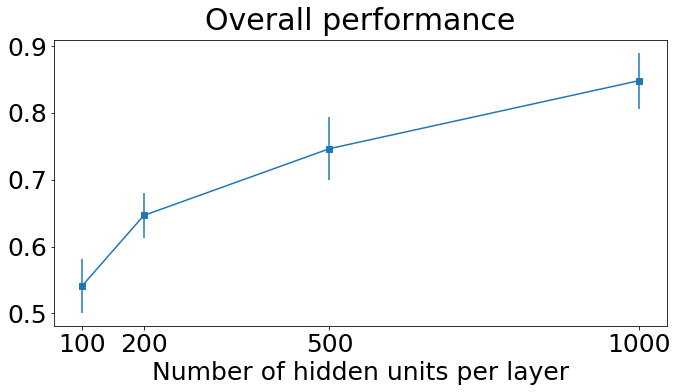

In [10]:


import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

def plot(db):
    stability, plasticity, overallAcc = all_values[db]

    x = []
    if db == "PAMAP":
        x = [100, 200, 500, 1000]
        
    elif db == "DSADS":
        x = [100, 200, 500, 1000]
    elif db == "HouseA":
        x = [20, 50, 100, 200]
    else:
        x = [50, 100, 200, 500]
        
    plotline(stability, "Stability of the model", x=x, filename=db+"h_unit_sta.pdf")
    plotline(plasticity, "Plasticity of the model", x=x, ylim=[1.0, 1.3], filename=db+"h_unit_pla.pdf")
    plotline(overallAcc, "Overall performance", x=x, filename=db+"h_unit_ova.pdf")
    
def plotline(values, title, x=None, ylim=None, filename="plot"):
    plt.rcParams['figure.figsize'] = [10, 6]
    plt.rcParams.update({'font.size': 25})
    plt.rcParams['axes.titlepad'] = 10
    
#     cmd = 0
#     model = "sg-cgan"
#     taskorder = 0
#     stability[cmd][model][taskorder]

#     models = ["mp-gan", "mp-wgan", "sg-cgan", "sg-cwgan"]
    models = ["sg-cgan"]
    
    y = {}
    for model in models:
        y[model] = []
        for c in range(len(values)):
            avg = np.nanmean(values[c][model])
            err = stats.sem(values[c][model], nan_policy="omit")
            y[model].append((avg, err))

    
    fig, ax = plt.subplots()
    
    patterns = [ "-s" , "-o" , "-x" , "-D" , "-+" , "-*", "-2" ]
    for i, model in enumerate(models):
        
        m = y[model]
        yval = [v for (v, e) in m]
        yerr = [e for (v, e) in m]
        print(model, yval)
        ax.errorbar(x, yval, yerr=yerr, fmt=patterns[i])

    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xlabel("Number of hidden units per layer")
    if ylim is not None:
        ax.set_ylim(ylim[0], ylim[1])
    ax.set_xticklabels(x)
#     ax.legend(models, prop={'size': 20}, loc=2)
#     ax.legend(["cGAN"], prop={'size': 20}, bbox_to_anchor=(1.05, 1), loc=0, borderaxespad=0.)

    
    fig.tight_layout()
    fig.savefig(filename, bbox_inches='tight')
    plt.show()
    
plot("PAMAP")

sg-cgan [0.9380891169094493, 0.8913940310839287, 0.9442542600311142, 0.9613811177376821]


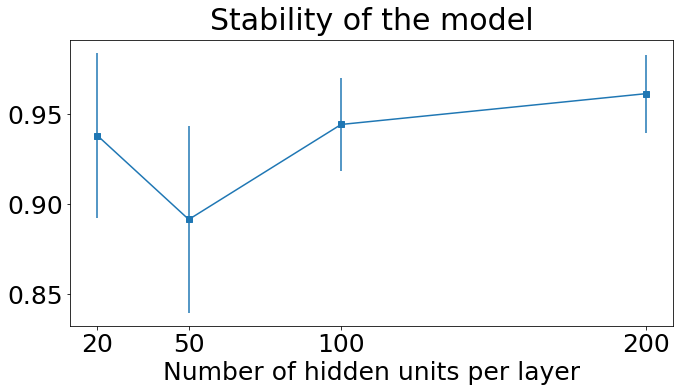

sg-cgan [0.9998263057160421, 1.0323851821762746, 1.008310362652647, 1.0209849192788167]


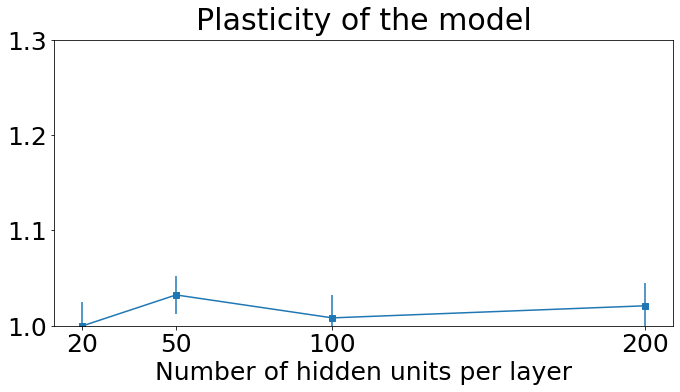

sg-cgan [0.8239211907624956, 0.8503030219655049, 0.8650385275425251, 0.8880082119287593]


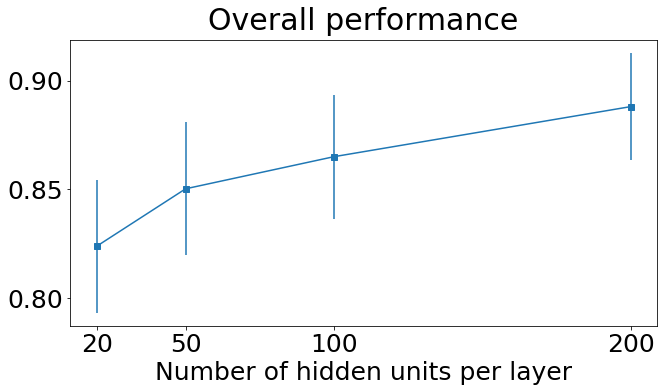

In [11]:
plot("HouseA")

sg-cgan [0.8872613247970985, 0.9349767413801662, 1.1021297008387276, 1.144796041207299]


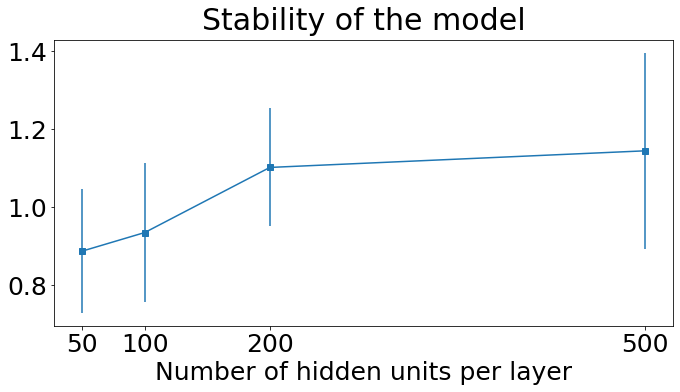

sg-cgan [1.032234797470401, 1.1096698929720596, 0.9530854155879744, 0.9863798167903157]


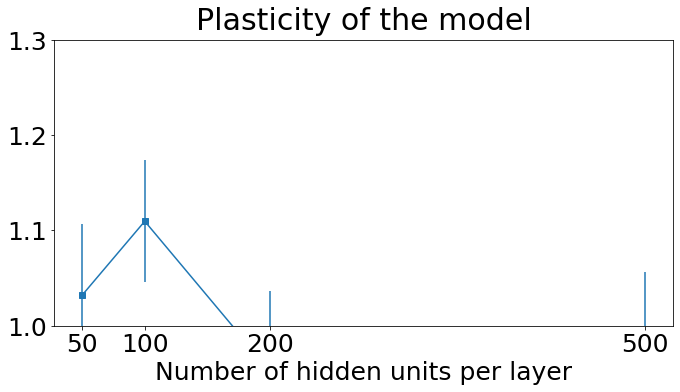

sg-cgan [0.7090068634237995, 0.765591135193218, 0.7034626524256374, 0.8272493884098946]


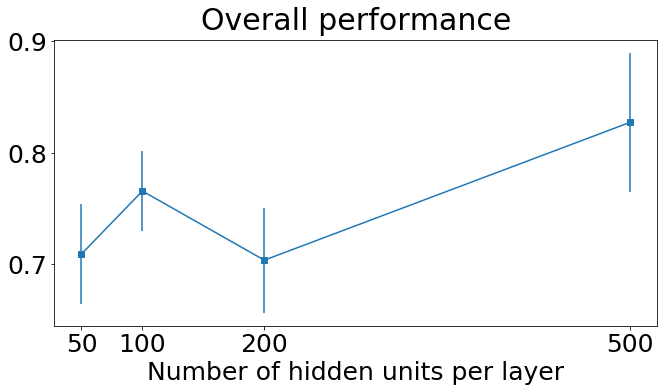

In [12]:
plot("CASAS")

sg-cgan [0.7786500880367493, 0.8025081468729031, 1.0106604336987768, 0.9722168109804217]


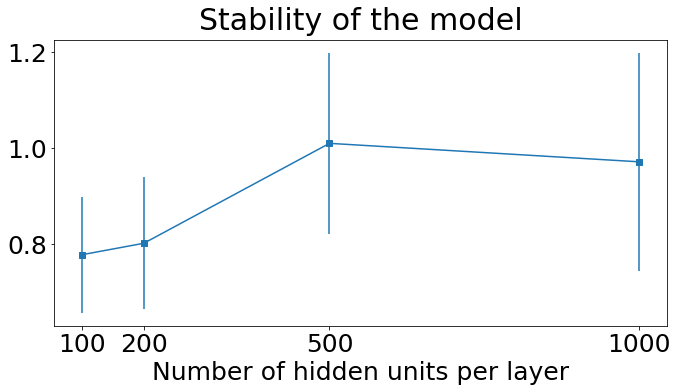

sg-cgan [1.33804765169661, 1.3477065133563157, 1.347569554266996, 1.3361394997367135]


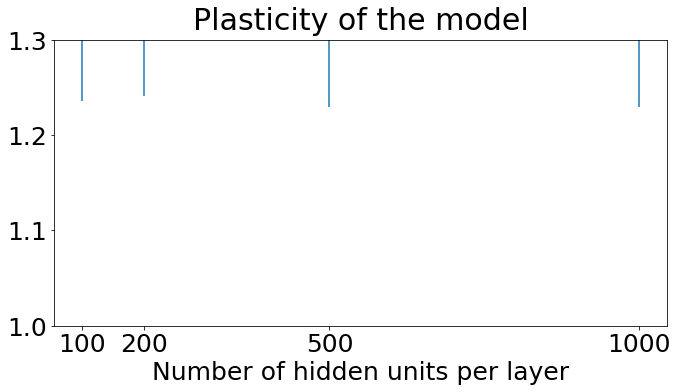

sg-cgan [0.6601393690476992, 0.7219127575462075, 0.7553183096501492, 0.7667648099578103]


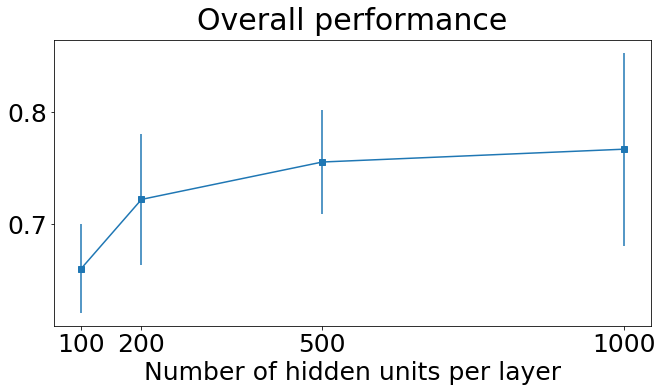

In [13]:
plot("DSADS")

# Replay important ratio

In [7]:
all_values = {}
for d in ["CASAS"]:
    dataset = d
    folder = "../../Results/"+dataset+"/exp_replay_important/"
    
    raw = pd.read_csv(folder+"results.txt")
    raw.columns = [c.strip() for c in raw.columns]
    raw["train_session"] = pd.to_numeric(raw["train_session"], errors='coerce')
    
    cmd = raw["cmd"].unique()
    task_order = raw["task_order"].unique()
    method = raw["method"].unique()

    stability = []
    plasticity = []
    overallAcc = []

    for c in cmd:
       
        target = raw[raw["cmd"]==c]
        m = calStability(target, task_order, method)
        stability.append(m)
        
        m = calPlasticity(target, task_order, method)
        plasticity.append(m)
        
        m = calOverallAcc(target, task_order, method)
        overallAcc.append(m)
        
    all_values[d] = (stability, plasticity, overallAcc)
    print(d, "DONE")

CASAS DONE


sg-cgan [0.861143514660953, 0.8320001587112644, 0.8529679006467483, 0.8092191405785025, 0.2536761496647224]


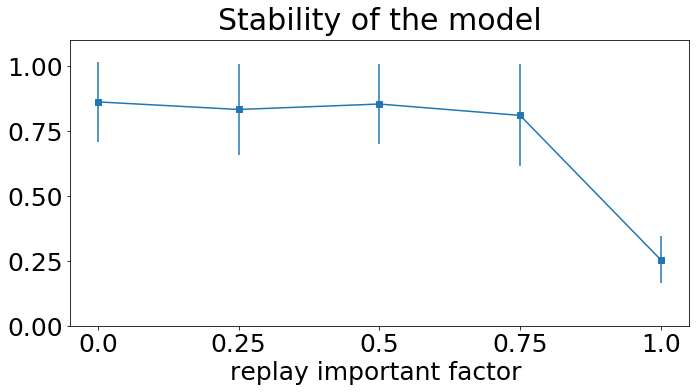

sg-cgan [0.17782010078165295, 0.9445855546862942, 0.9460415542389919, 0.9497728387989475, 0.9626461472026699]


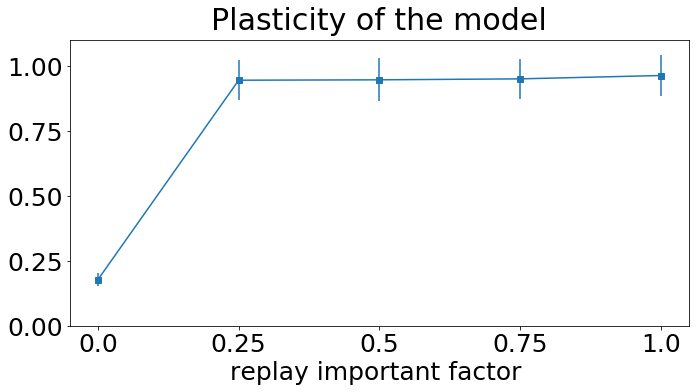

sg-cgan [0.17029321906122286, 0.7745297723909502, 0.8269132150114349, 0.7201066456907667, 0.3467247004829356]


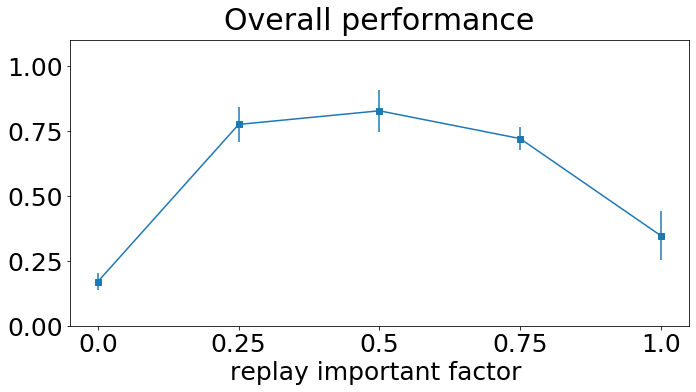

In [13]:
def plotline(values, title, x=None, filename="plot"):
#     cmd = 0
#     model = "sg-cgan"
#     taskorder = 0
#     stability[cmd][model][taskorder]

    models = ["sg-cgan"]
    plt.rcParams['figure.figsize'] = [10, 6]
    plt.rcParams.update({'font.size': 25})
    
    y = {}
    for model in models:
        y[model] = []
        for c in range(len(values)):
            avg = np.nanmean(values[c][model])
            err = stats.sem(values[c][model], nan_policy="omit")
            y[model].append((avg, err))

    fig, ax = plt.subplots()
    
    patterns = [ "-s" , "-o" , "-x" , "-D" , "-+" , "-*", "-2" ]
    for i, model in enumerate(models):
        
        m = y[model]
        yval = [v for (v, e) in m]
        yerr = [e for (v, e) in m]
        print(model, yval)
        ax.errorbar(x, yval, yerr=yerr, fmt=patterns[i])

    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xlabel("replay important factor ")
    ax.set_ylim(0, 1.1)
    ax.set_xticklabels(x)
#     ax.legend(models, prop={'size': 20}, loc=2)
#     ax.legend(["cGAN"], prop={'size': 20}, bbox_to_anchor=(1.05, 1), loc=0, borderaxespad=0.)

    
    fig.tight_layout()
    fig.savefig(filename, bbox_inches='tight')
    plt.show()
    
def plot(db):
    
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.rcParams.update({'font.size': 20})
    plt.rcParams['axes.titlepad'] = 10
    
    stability, plasticity, overallAcc = all_values[db]

    x = [0.0, 0.25, 0.5, 0.75, 1.0]
    plotline(stability, "Stability of the model", x=x, filename="rnt-sta.pdf")
    plotline(plasticity, "Plasticity of the model", x=x, filename="rnt-pla.pdf")
    plotline(overallAcc, "Overall performance", x=x, filename="rnt-ova.pdf")
    
plot("CASAS")